# Frequentist vs Bayesianism part 1
Jake VanderPlas

http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

In [1]:
try:
    import numpy as np, pandas as pd, matplotlib.pyplot as plt, pymc3 as pm, emcee
except:
    ! conda install -y emcee
    import numpy as np, pandas as pd, matplotlib.pyplot as plt, pymc3 as pm, emcee

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - emcee


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py37h89c1867_1         143 KB  conda-forge
    emcee-3.0.2                |     pyh5ca1d4c_0          31 KB  conda-forge
    mpi-1.0                    |          openmpi           4 KB  conda-forge
    mpi4py-3.0.3               |   py37h4bc35b6_2         641 KB  conda-forge
    openmpi-4.0.2              |       hb1b8bf9_1         3.5 MB
    schwimmbad-0.3.1           |   py37hc8dfbb8_1          22 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following NEW packages will be INSTALLED:

  emcee              conda-forge/noarch::emcee-3.0.2-pyh5ca1d4c_0
  mpi                conda-forge/li

# Frequentist and Bayesian Approaches in Practice: Counting Photons

## Photon Counts: the frequentist approach

In [20]:
def report(F_true, est_mean, est_std, N):
    print(f'F_true = {F_true}\nF_est  = {est_mean:.0f} +/- {est_std:.0f} (based on {N} measurements)')

In [23]:
# Generating some simple photon count data
rng = np.random.default_rng(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = rng.poisson(F_true, N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root
w = e ** (-2)
report(F_true, (w * F).sum() / w.sum(), w.sum() ** -0.5, N)

F_true = 1000
F_est  = 1003 +/- 4 (based on 50 measurements)


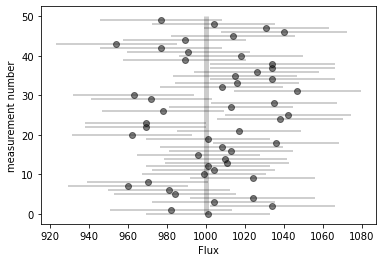

In [25]:
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux")
ax.set_ylabel("measurement number");

## Photon Counts: the Bayesian approach

In [8]:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2) + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

In [31]:
ndim = 1  # number of parameters in the model
nwalkers = N  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
rng = np.random.default_rng(1)  # for repeatability
starting_guesses = 2000 * rng.uniform(0, 1, (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # throw out first nburn steps to let chain stabilize, then reshape to (ndim, nsamples)

report(F_true, sample.mean(), sample.std(), N)

Text(0, 0.5, 'P(F)')

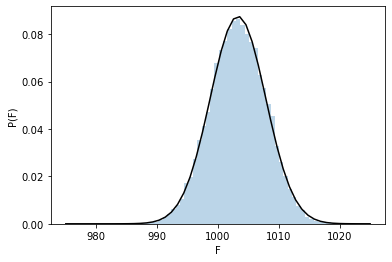

In [35]:
from scipy.stats import norm

# plot a histogram of the sample
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, density=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = norm(sample.mean(), sample.std()).pdf(F_fit)

plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)")

# Adding a Dimension: Exploring a more sophisticated model

## Varying Photon Counts: The Bayesian Approach

In [50]:
def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = rng.uniform(0, 1, (nwalkers, ndim))
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim).T

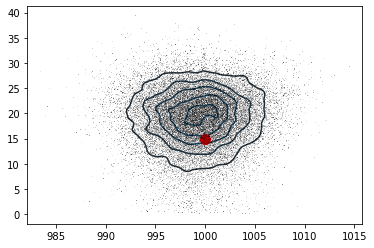

In [70]:
# from astroML.plotting import plot_mcmc
import seaborn as sns
plt.plot([mu_true], [sigma_true], 'o', color='red', ms=10);
plt.plot(sample[0], sample[1], ',k', alpha=0.1)
sns.kdeplot(sample[0], sample[1], levels=5)